In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import wandb
import io
import os
from PIL import Image
from torch.utils.data import Dataset
from DeepFeatures import DeepFeatures

ModuleNotFoundError: No module named 'torch'

In [4]:
!conda install -c conda-forge torch -y

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.



PackagesNotFoundError: The following packages are not available from current channels:

  - torch

Current channels:

  - https://conda.anaconda.org/conda-forge/win-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [5]:
conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch -y

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\ctmer\anaconda3\envs\MovieWeb

  added / updated specs:
    - cudatoolkit=11.3
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pytorch-1.10.0             |py3.9_cuda11.3_cudnn8_0        1.45 GB  pytorch
    ------------------------------------------------------------
                                           Total:        1.45 GB

The following NEW packages will be INSTALLED:

  blas               pkgs/main/win-64::blas-1.0-mkl
  cudatoolkit        pkgs/main/win-64::cudatoolkit-11.3.1-h59b6b97_2
  freetype           pkgs/main/win-64::freetype-2.10.4-hd328e21_0
  jpeg               pkgs/main/win-64::jpeg-9d-h2bbff1b_0
  libpng             pkgs/main/win-64::libpng-1.6.37-h2a8f88b_0
  libtiff            pkgs/main/win-64::libtiff-4.2.0-hd0e1b90_0
 

In [7]:
!nvidia-smi

Sun Nov 21 10:02:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 18%   35C    P8    34W / 250W |   1172MiB / 11264MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
WANDB_ON = True
SWEEP_ON = True
COUNT = None

In [3]:
class IMDB(Dataset):
    def __init__(self, URL: str = "https://web.archive.org/web/20211012141319/https://www.imdb.com/chart/top-english-movies/", IMG_SIZE: tuple = (44,64)):
        self.URL = URL
        self.IMG_SIZE = IMG_SIZE
        self.transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        page = requests.get(URL)
        soup = BeautifulSoup(page.content, 'html.parser')
        movie_list = soup.find(class_='lister-list')
        movie_elems = movie_list.find_all('tr')
    
        movTitle = []
        movYear = []
        movRating = []
        movPoster = []

        for i, elm in enumerate(movie_elems):
            title = elm.find('td', 'titleColumn').a['title']
            movTitle.append(title)
            year = int(elm.find('td', 'titleColumn').span.string[1:-1])
            movYear.append(year)
            rating = float(elm.find('td', 'ratingColumn imdbRating').strong.string)
            movRating.append(rating)
            posterURL = elm.find('td', 'posterColumn').a.img['src']
            data = requests.get(posterURL).content
            img = Image.open(io.BytesIO(data)).resize(IMG_SIZE)
            array = np.array(img, dtype='uint8')
            movPoster.append(array)
            if i >= 150:
                break

        imdb = {'Movie Title':movTitle, 'Year Published':movYear, 'IMDb Rating':movRating, 'Movie Poster': movPoster}
        self.df = pd.DataFrame(imdb)


    def __len__(self):
        return self.df.shape[0]


    def __getitem__(self, index:int) -> np.ndarray:
        image = self.transform(self.df['Movie Poster'][index])
        return image
    
    def displayImage(self, index:int):
        image = self.df['Movie Poster'][index]
        plt.imshow(image)

NameError: name 'Dataset' is not defined

In [ ]:
if WANDB_ON:
    !wandb login

wandb: Currently logged in as: cmerrill (use `wandb login --relogin` to force relogin)


In [ ]:
if WANDB_ON and SWEEP_ON:
    sweep_config = {
        "name": "MovieWeb",
        "method": "bayes",
        "metric": {
            "name": "test_loss",
            "goal": "minimize"
        },
        "parameters": {
            "learning_rate": {
                "distribution": "uniform",
                "min": 0.0001,
                "max": 0.01
            },
            "optimizer": {
                "values": ["Adam"]
            },
            "epochs":{
                "distribution": "normal",
                "mu": 1000,
                "sigma": 250,
            },
            "batch_size": {
                "distribution": "int_uniform",
                "min": 4,
                "max": 256
            },
            "random_seed": {
                "values": [42]
            },
            "validation_split": {
                "values": [.2]
            },
            "shuffle_dataset": {
                "values": [True]
            }
        }
    }

    sweep_id = wandb.sweep(sweep_config, project='MovieWeb', entity='cmerrill')

Create sweep with ID: 7yy2knc9
Sweep URL: https://wandb.ai/cmerrill/MovieWeb/sweeps/7yy2knc9


In [ ]:

#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.embedding_size = None
        
        #Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
            
        )
       
        #Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x) -> torch.Tensor:
        x = self.encoder(x)
        if x.size() != self.embedding_size:
            self.embedding_size = x.size()
        x = self.decoder(x)
        return x

    def embedding(self, x) -> torch.Tensor:
        x = torch.flatten(self.encoder(x), start_dim=1).T
        return x

    def count_parameters(self) -> int:
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [ ]:
def compression_ratio():
    temp_db = IMDB()
    x = temp_db.__getitem__(0)
    model = ConvAutoencoder()
    x = torch.reshape(x, (1,*x.shape))
    _ = model.forward(x)
    cr = np.prod(x.shape) / np.prod(model.embedding_size)
    return cr



print(f'Compression ratio: {compression_ratio()}:1')

IndexError: index out of bounds

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [ ]:
def train():
    # get_device()
    with wandb.init(project='MovieWeb', entity='cmerrill') if WANDB_ON else None as run:
        config = {}
        config['learning_rate'] = 0.1
        config['batch_size'] = 4
        config['epochs'] = 2000
        config['validation_split'] = 0.2
        config['shuffle_dataset'] = True
        config['random_seed'] = 42
        config['optimizer'] = "SGD"
        
        if WANDB_ON:
            config.update(wandb.config)
        
        config['epochs'] = int(config['epochs'])
        print(config)
        
        # Creating data indices for training and validation splits:
        imdbDataset = IMDB()
        dataset_size = len(imdbDataset)
        indices = list(range(dataset_size))
        split = int(np.floor(config['validation_split'] * dataset_size))
        if config['shuffle_dataset'] :
            np.random.seed(config['random_seed'])
            np.random.shuffle(indices)
        train_indices, test_indices = indices[split:], indices[:split]

        # Creating PT data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SubsetRandomSampler(test_indices)

        train_loader = torch.utils.data.DataLoader(
            imdbDataset, 
            batch_size=config['batch_size'], 
            sampler=train_sampler
        )

        test_loader = torch.utils.data.DataLoader(
            imdbDataset, 
            batch_size=config['batch_size'],
            sampler=test_sampler
        )

        #Instantiate the model
        model = ConvAutoencoder()
        model.cuda()

        if WANDB_ON:
            wandb.watch(model)

        #Loss function
        criterion = nn.MSELoss()

        #Optimizer
        optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), lr = config['learning_rate'])

        for epoch in range(1, config['epochs']+1):
            # monitor training loss
            train_loss = 0.0
            
            # Training
            for images in train_loader:
                images = images.cuda()
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, images)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()*images.size(0)
                
            train_loss = train_loss/len(train_loader)
            
            if WANDB_ON:
                wandb.log({"loss": train_loss})

            #monitor testing loss
            test_loss = 0.0

            # Testing
            for images in test_loader:
                images = images.cuda()
                outputs = model(images)
                loss = criterion(outputs, images)
                test_loss += loss.item()*images.size(0)
            
            test_loss = test_loss/len(test_loader)
            
            if WANDB_ON:
                wandb.log({"test_loss": test_loss})

            print('Epoch {} | Train Loss: {:.4f} |  Test Loss: {:.4f}'.format(epoch, train_loss, test_loss))

        #Batch of test images
        dataiter = iter(train_loader)
        images = dataiter.next()
        images = images.cuda()

        #Sample outputs
        outputs = model(images)
        images = images.cpu().data.numpy()
        outputs = outputs.cpu().data.numpy()

        #Original Images
        f, axarr = plt.subplots(1,4,figsize=(12,12))
        for idx in np.arange(4):
            axarr[idx].imshow(np.moveaxis(images[idx], 0, -1))
            axarr[idx].tick_params(
                left=False, 
                right=False , 
                labelleft=False ,
                labelbottom=False, 
                bottom=False
            )
        if WANDB_ON:
            wandb.log({"true_images": plt})
        else:
            plt.show()

        #Reconstructed Images
        f, axarr = plt.subplots(1,4,figsize=(12,12))
        for idx in np.arange(4):
            axarr[idx].imshow(np.moveaxis(outputs[idx], 0, -1))
            axarr[idx].tick_params(
                left=False, 
                right=False , 
                labelleft=False ,
                labelbottom=False, 
                bottom=False
            )

        if WANDB_ON:
            wandb.log({"reconstructed_images": plt})
        else:
            plt.show()

        if WANDB_ON:
            # Save your model.
            torch.save(model.state_dict(), './saved_models/model.pth')
            # Save as artifact for version control.
            artifact = wandb.Artifact(f'model', type='model')
            artifact.add_file('./saved_models/model.pth')
            run.log_artifact(artifact, aliases=['latest', run.name])
            run.join()
            # Delete the file from the saved_models folder.
            os.remove('./saved_models/model.pth')
            run.finish()

wandb: Agent Starting Run: vfxhmtj2 with config:
wandb: 	batch_size: 60
wandb: 	epochs: 1303.1308096082028
wandb: 	learning_rate: 0.0094079655765989
wandb: 	optimizer: Adam
wandb: 	random_seed: 42
wandb: 	shuffle_dataset: True
wandb: 	validation_split: 0.2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cmerrill (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep
wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'learning_rate': 0.0094079655765989, 'batch_size': 60, 'epochs': 1303, 'validation_split': 0.2, 'shuffle_dataset': True, 'random_seed': 42, 'optimizer': 'Adam'}
Epoch 1 | Train Loss: 4.9367 |  Test Loss: 3.5064
Epoch 2 | Train Loss: 4.8753 |  Test Loss: 3.4723
Epoch 3 | Train Loss: 4.8101 |  Test Loss: 3.4247
Epoch 4 | Train Loss: 4.7311 |  Test Loss: 3.3630
Epoch 5 | Train Loss: 4.6332 |  Test Loss: 3.2899
Epoch 6 | Train Loss: 4.5263 |  Test Loss: 3.1772
Epoch 7 | Train Loss: 4.3670 |  Test Loss: 3.0225
Epoch 8 | Train Loss: 4.1370 |  Test Loss: 2.8007
Epoch 9 | Train Loss: 3.8524 |  Test Loss: 2.5741
Epoch 10 | Train Loss: 3.5302 |  Test Loss: 2.3378
Epoch 11 | Train Loss: 3.3159 |  Test Loss: 2.0645
Epoch 12 | Train Loss: 2.9089 |  Test Loss: 2.2287
Epoch 13 | Train Loss: 2.9677 |  Test Loss: 1.6812
Epoch 14 | Train Loss: 2.4921 |  Test Loss: 1.5699
Epoch 15 | Train Loss: 2.2709 |  Test Loss: 1.5377
Epoch 16 | Train Loss: 2.2825 |  Test Loss: 1.3199
Epoch 17 | Train Loss: 2.0637 |

loss,1.04186
_runtime,49
_timestamp,1635079527
_step,2607
test_loss,0.72409


loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▄▃▃▄▃▂▅▂▃▂▁▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: cxr39ssq with config:
wandb: 	batch_size: 143
wandb: 	epochs: 881.9273385299362
wandb: 	learning_rate: 0.005643226406103491
wandb: 	optimizer: Adam
wandb: 	random_seed: 42
wandb: 	shuffle_dataset: True
wandb: 	validation_split: 0.2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep
wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'learning_rate': 0.005643226406103491, 'batch_size': 143, 'epochs': 881, 'validation_split': 0.2, 'shuffle_dataset': True, 'random_seed': 42, 'optimizer': 'Adam'}
Epoch 1 | Train Loss: 16.7224 |  Test Loss: 3.8637
Epoch 2 | Train Loss: 16.6168 |  Test Loss: 3.8435
Epoch 3 | Train Loss: 16.5181 |  Test Loss: 3.8238
Epoch 4 | Train Loss: 16.4223 |  Test Loss: 3.8038
Epoch 5 | Train Loss: 16.3251 |  Test Loss: 3.7835
Epoch 6 | Train Loss: 16.2256 |  Test Loss: 3.7629
Epoch 7 | Train Loss: 16.1235 |  Test Loss: 3.7413
Epoch 8 | Train Loss: 16.0168 |  Test Loss: 3.7183
Epoch 9 | Train Loss: 15.9035 |  Test Loss: 3.6925
Epoch 10 | Train Loss: 15.7779 |  Test Loss: 3.6641
Epoch 11 | Train Loss: 15.6400 |  Test Loss: 3.6323
Epoch 12 | Train Loss: 15.4860 |  Test Loss: 3.5957
Epoch 13 | Train Loss: 15.3101 |  Test Loss: 3.5532
Epoch 14 | Train Loss: 15.1079 |  Test Loss: 3.5035
Epoch 15 | Train Loss: 14.8747 |  Test Loss: 3.4458
Epoch 16 | Train Loss: 14.6073 |  Test Loss: 3.3796
Epoch 17 | Tr

loss,2.42195
_runtime,28
_timestamp,1635079561
_step,1763
test_loss,0.58856


loss,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: i538iggp with config:
wandb: 	batch_size: 198
wandb: 	epochs: 911.9758441059344
wandb: 	learning_rate: 0.006622293699264836
wandb: 	optimizer: Adam
wandb: 	random_seed: 42
wandb: 	shuffle_dataset: True
wandb: 	validation_split: 0.2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep
wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


{'learning_rate': 0.006622293699264836, 'batch_size': 198, 'epochs': 911, 'validation_split': 0.2, 'shuffle_dataset': True, 'random_seed': 42, 'optimizer': 'Adam'}
Epoch 1 | Train Loss: 15.5986 |  Test Loss: 3.6515
Epoch 2 | Train Loss: 15.5167 |  Test Loss: 3.6374
Epoch 3 | Train Loss: 15.4411 |  Test Loss: 3.6231
Epoch 4 | Train Loss: 15.3637 |  Test Loss: 3.6088
Epoch 5 | Train Loss: 15.2851 |  Test Loss: 3.5944
Epoch 6 | Train Loss: 15.2050 |  Test Loss: 3.5796
Epoch 7 | Train Loss: 15.1220 |  Test Loss: 3.5650
Epoch 8 | Train Loss: 15.0359 |  Test Loss: 3.5509
Epoch 9 | Train Loss: 14.9500 |  Test Loss: 3.5369
Epoch 10 | Train Loss: 14.8630 |  Test Loss: 3.5224
Epoch 11 | Train Loss: 14.7735 |  Test Loss: 3.5067
Epoch 12 | Train Loss: 14.6798 |  Test Loss: 3.4894
Epoch 13 | Train Loss: 14.5796 |  Test Loss: 3.4716
Epoch 14 | Train Loss: 14.4767 |  Test Loss: 3.4546
Epoch 15 | Train Loss: 14.3742 |  Test Loss: 3.4369
Epoch 16 | Train Loss: 14.2636 |  Test Loss: 3.4194
Epoch 17 | Tr

loss,4.42867
_runtime,29
_timestamp,1635079596
_step,1823
test_loss,0.9594


loss,█▇▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▇▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


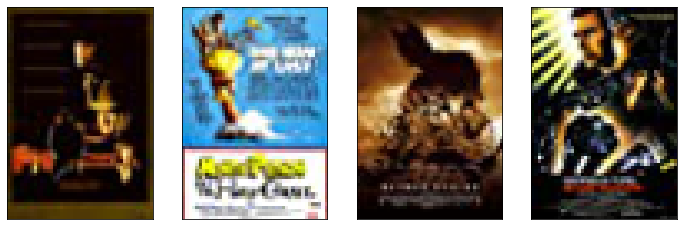

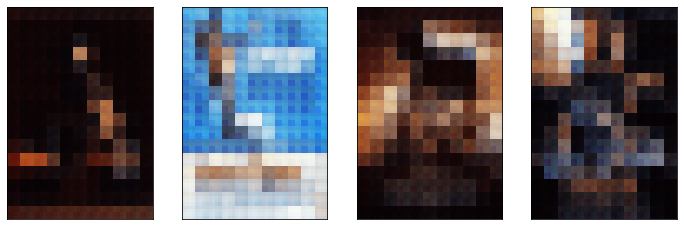

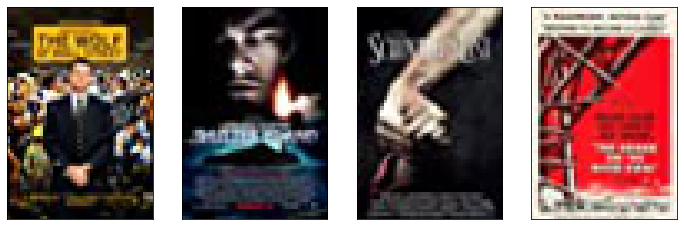

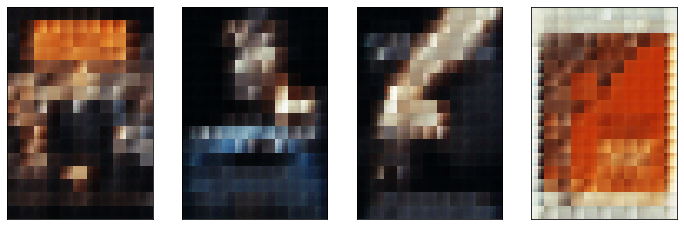

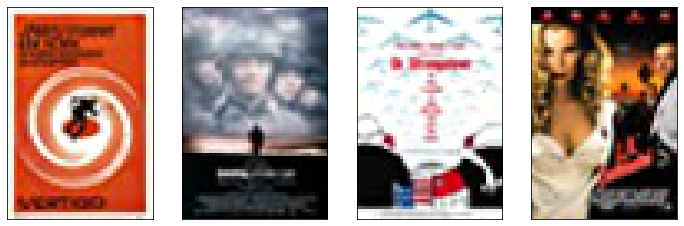

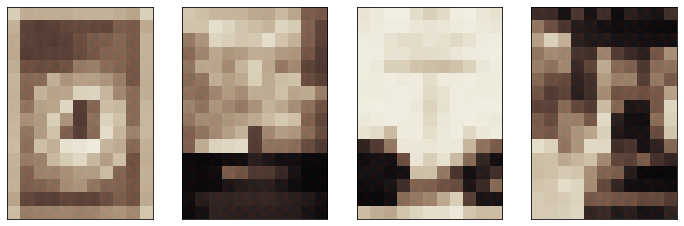

In [ ]:
if WANDB_ON:
    if SWEEP_ON:
        wandb.agent(sweep_id, function=train, count=COUNT)
    else:
        train()

- Run all of the data through the model to get the embedding for each poster

In [ ]:
def getBestModel(sweep_id):
    api = wandb.Api()

    sweep = api.sweep(f"cmerrill/MovieWeb/{sweep_id}")
    runs = sorted(sweep.runs,
        key=lambda run: run.summary.get("test_loss", 0))
    runs = list(filter(lambda run: run.summary.get("test_loss") not in [0,None],runs))
    test_loss = runs[0].summary.get("name", 0)
    print(f"Best run {runs[0].name} with {test_loss} test loss")

    run = wandb.init()
    artifact = run.use_artifact(f'cmerrill/MovieWeb/model:{runs[0].name}', type='model')
    artifact_dir = artifact.download()
    model = ConvAutoencoder()
    checkpoint = torch.load(os.path.join(artifact_dir, 'model.pth'))
    model.load_state_dict(checkpoint)
    
    return model

In [ ]:
model = getBestModel('wd6dnfqw')

wandb: Currently logged in as: cmerrill (use `wandb login --relogin` to force relogin)


Best run absurd-sweep-55 with 0 test loss


wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
def validateBestModel(model):
    
    imdbDataset = IMDB()
    # Creating data indices for training and validation splits:
    dataset_size = len(imdbDataset)
    indices = list(range(dataset_size))
    split = int(np.floor(.2 * dataset_size))
    np.random.seed(42)
    np.random.shuffle(indices)
    test_indices = indices[:split]

    # Creating PyTorch data samplers and loaders:
    test_sampler = SubsetRandomSampler(test_indices)

    test_loader = torch.utils.data.DataLoader(
        imdbDataset, 
        batch_size=8,
        sampler=test_sampler
    )

    #Batch of test images
    dataiter = iter(test_loader)
    images = dataiter.next()
    # images = images.cuda()

    #Sample outputs
    outputs = model(images)
    images = images.cpu().data.numpy()
    outputs = outputs.cpu().data.numpy()

    #Original Images
    print("Test Images")
    f, axarr = plt.subplots(1,8,figsize=(12,12))
    for idx in np.arange(8):
        axarr[idx].imshow(np.moveaxis(images[idx], 0, -1))
        axarr[idx].tick_params(
            left=False, 
            right=False , 
            labelleft=False ,
            labelbottom=False, 
            bottom=False
        )
    plt.show()

    #Reconstructed Images
    print('Reconstructed Images')
    f, axarr = plt.subplots(1,8,figsize=(12,12))
    for idx in np.arange(8):
        axarr[idx].imshow(np.moveaxis(outputs[idx], 0, -1))
        axarr[idx].tick_params(
            left=False, 
            right=False , 
            labelleft=False ,
            labelbottom=False, 
            bottom=False
        )
    plt.show()

Test Images


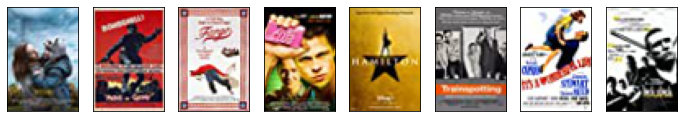

Reconstructed Images


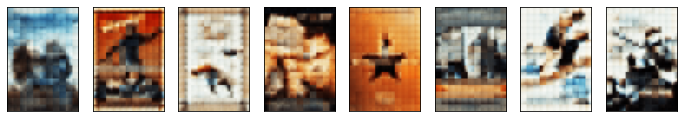

In [ ]:
validateBestModel(model)

In [ ]:
def display_embeddings(model, expirement_name):
    imdbDataset = IMDB(IMG_SIZE=(32,32))
    
    # Creating PT data samplers and loaders:
    data_loader = torch.utils.data.DataLoader(
        imdbDataset, 
        batch_size=8,
    )

    #Batch of test images
    dataiter = iter(data_loader)
    images = dataiter.next()
    images = images.cpu()

    DF = DeepFeatures(model = model, 
                  imgs_folder = './images', 
                  embs_folder = './embs', 
                  tensorboard_folder = './tensorboard', 
                  experiment_name=expirement_name)

    DF.write_embeddings(x = images, outsize=imdbDataset.IMG_SIZE)

    DF.create_tensorboard_log()

    #config = projector.ProjectorConfig()
    
    #model.embedding(images)

    #projector.visualize_embeddings(log_dir, config)

In [ ]:
display_embeddings(model, 'wd6dnfqw')

AssertionError: Images folder must be empty

https://shairozsohail.medium.com/exploring-deep-embeddings-fa677f0e7c90

https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin